In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime

In [5]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

In [4]:
csv_path = '/Users/pbadami/Documents/njtransit/csv'

<b>What is the 'business question' I am trying to answer with this analysis?</b>

1) How bad is the morning commute on NJ Transit? <br/>
2) How bad is the morning commute on NJ Transit to New York Penn? <br/>
3) Who had the worst morning commute on NJ Transit in the past two weeks? <br/>
4) A "Day in the Life" of an NJ Transit weekday commuter to NY Penn? --> Fill in station, time (more work) <br/>

# Setup

In [5]:
week1 = ['2018_02_05', '2018_02_06', '2018_02_07', '2018_02_08', '2018_02_09']
week2 = ['2018_02_12', '2018_02_13', '2018_02_14', '2018_02_15', '2018_02_16']
#week3 = ['2018_02_19', '2018_02_20', '2018_02_21', '2018_02_22', '2018_02_23']
weekdays = week1 + week2 #+ week3

In [6]:
weekdays_df = None
for day in weekdays:
    day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))
    if weekdays_df is None:
        weekdays_df = day_df
    else:
        weekdays_df = weekdays_df.append(day_df, ignore_index=True)

In [8]:
weekdays_df['expected'] = pd.to_datetime(weekdays_df['expected'])
weekdays_df['time'] = pd.to_datetime(weekdays_df['time'])

weekdays_df['delay']=(weekdays_df['time']-weekdays_df['expected']).dt.total_seconds() #calculate delay in seconds
weekdays_df['delay']=(weekdays_df['time']-weekdays_df['expected']).dt.total_seconds() #calculate delay in seconds

In [9]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec
weekdays_df['delay'] = weekdays_df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes

In [10]:
def get_bucket(dep_time):
    bucket = 30*60 # 15 min. buckets
    dep_day = datetime(year=dep_time.year, month=dep_time.month, day=dep_time.day)
    diff = dep_time - dep_day
    return int(diff.total_seconds() / bucket) * bucket

In [11]:
weekdays_df['bucket'] = weekdays_df['time'].apply(get_bucket)

In [12]:
weekdays_df['status'] = weekdays_df['status'].fillna("Estimated")

In [292]:
weekdays_df['status'].unique()

array(['Departed', 'Estimated', 'Cancelled'], dtype=object)

In [13]:
trains = weekdays_df.groupby(['train_id', 'date'])

In [14]:
trains.get_group(('3928', '2018-02-05'))

,train_id,date,stop_sequence,from,from_id,to,to_id,expected,time,status,line,type,delay,bucket
275,3928,2018-02-05,1.0,Trenton,148.0,Trenton,148.0,2018-02-05 07:50:00,2018-02-05 07:52:05,Departed,Northeast Corrdr,NJ Transit,2.083333,27000
276,3928,2018-02-05,2.0,Trenton,148.0,Hamilton,32905.0,2018-02-05 07:57:00,2018-02-05 07:57:05,Departed,Northeast Corrdr,NJ Transit,0.083333,27000
277,3928,2018-02-05,3.0,Hamilton,32905.0,Princeton Junction,125.0,2018-02-05 08:05:00,2018-02-05 08:05:15,Departed,Northeast Corrdr,NJ Transit,0.250000,28800
278,3928,2018-02-05,4.0,Princeton Junction,125.0,New Brunswick,103.0,2018-02-05 08:21:00,2018-02-05 08:21:07,Departed,Northeast Corrdr,NJ Transit,0.116667,28800
279,3928,2018-02-05,5.0,New Brunswick,103.0,Metropark,83.0,2018-02-05 08:31:00,2018-02-05 08:35:03,Departed,Northeast Corrdr,NJ Transit,4.050000,30600
280,3928,2018-02-05,6.0,Metropark,83.0,Newark Airport,37953.0,2018-02-05 08:44:00,2018-02-05 08:50:02,Departed,Northeast Corrdr,NJ Transit,6.033333,30600
281,3928,2018-02-05,7.0,Newark Airport,37953.0,Newark Penn Station,107.0,2018-02-05 08:51:00,2018-02-05 08:58:10,Departed,Northeast Corrdr,NJ Transit,7.166667,30600
282,3928,2018-02-05,8.0,Newark Penn Station,107.0,Secaucus Upper Lvl,38187.0,2018-02-05 09:00:00,2018-02-05 09:06:07,Departed,Northeast Corrdr,NJ Transit,6.116667,32400
283,3928,2018-02-05,9.0,Secaucus Upper Lvl,38187.0,New York Penn Station,105.0,2018-02-05 09:14:00,2018-02-05 09:34:00,Estimated,Northeast Corrdr,NJ Transit,20.000000,34200


In [15]:
trains_last = trains.last()

In [16]:
trains_first = trains.first()

In [17]:
delay_by_bucket = trains_last.groupby('bucket')

In [18]:
valid_bucket_delays = delay_by_bucket.filter(lambda x: len(x) >= 50).groupby('bucket')

In [19]:
plt.style.use('fivethirtyeight')

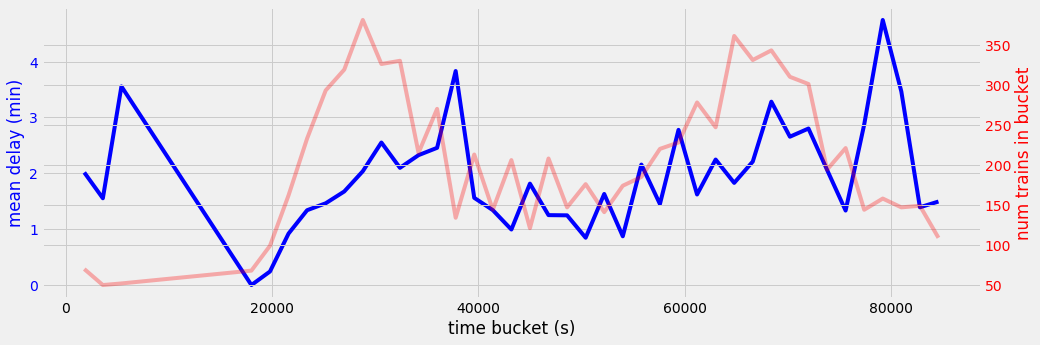

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
delay_mean = valid_bucket_delays['delay'].mean()
delay_mean = delay_mean[delay_mean.index > 900]
sizes = valid_bucket_delays['delay'].size()
sizes = sizes[sizes.index > 900]

ax.plot(delay_mean, 'b-')
ax.set_xlabel('time bucket (s)')
# # Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('mean delay (min)', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
# s2 = np.sin(2 * np.pi * t)
ax2.plot(sizes, 'r-', alpha=0.3)
ax2.set_ylabel('num trains in bucket', color='r')
ax2.tick_params('y', colors='r')

# fig.tight_layout()
# plt.show()

In [21]:
to_nyp = trains_last[(trains_last['type']=="NJ Transit") & (trains_last['to']=="New York Penn Station")].copy()
to_nyp_bucket = to_nyp.groupby('bucket')

In [22]:
from_nyp = trains_first[(trains_first['type']=="NJ Transit") & (trains_first['from']=="New York Penn Station")].copy()
from_nyp_bucket = from_nyp.groupby('bucket')

In [23]:
valid_to_nyp_bucket = to_nyp_bucket.filter(lambda x: len(x) >= 20).groupby('bucket')
valid_from_nyp_bucket = from_nyp_bucket.filter(lambda x: len(x) >= 20).groupby('bucket')


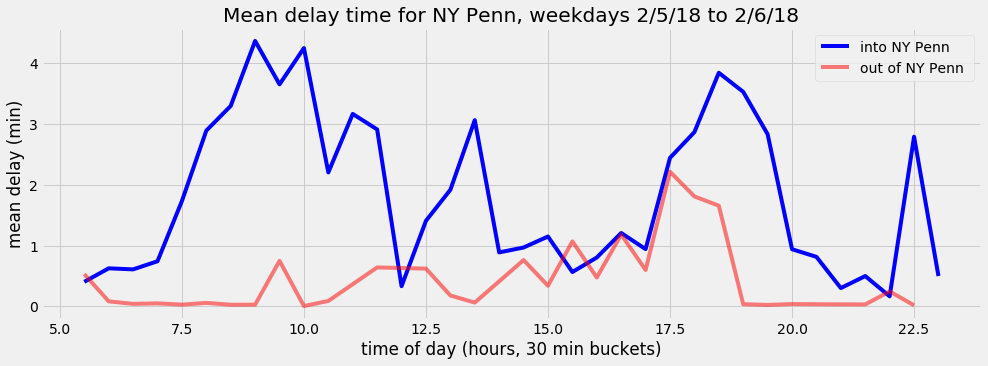

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
delay_mean = valid_to_nyp_bucket['delay'].mean()
delay_mean = delay_mean[delay_mean.index > 900]
delay_mean_from = valid_from_nyp_bucket['delay'].mean()
delay_mean_from = delay_mean_from[delay_mean_from.index > 900]


to_line = ax.plot(delay_mean.index/(3600.0), delay_mean, 'b-', label="delay into NY Penn")
ax.set_xlabel('time of day (hours, 30 min buckets)')
# # Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('mean delay (min)')
ax.tick_params('y')

# # s2 = np.sin(2 * np.pi * t)
from_line = ax.plot(delay_mean_from.index/(3600.0), delay_mean_from, 'r-', alpha=0.5)
# ax2.set_ylabel('num trains in bucket', color='r')
# ax2.tick_params('y', colors='r')
ax.legend(['into NY Penn', 'out of NY Penn '])

ax.set(title='Mean delay time for NY Penn, weekdays 2/5/18 to 2/6/18')

- Percent trains delayed for bucket --> small, heavy
- Percent trains delayed 

In [27]:
to_nyp_high_vol = to_nyp[to_nyp['line'].isin(['No Jersey Coast', 'Northeast Corrdr'])].copy()

In [28]:
to_nyp_hv_bucket = to_nyp_high_vol.groupby(('bucket', 'line'))

In [29]:
delay_by_line = to_nyp_hv_bucket['delay'].mean().unstack()

In [30]:
delay_by_line.fillna(0, inplace=True)

In [31]:
delay_by_line['time_of_day'] = delay_by_line.index/3600.0

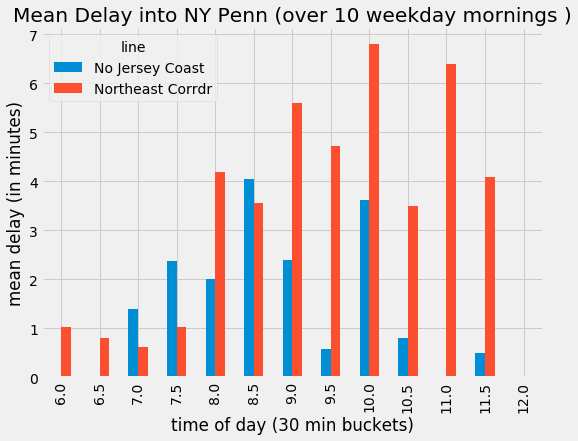

In [48]:
morning_delay = delay_by_line[(delay_by_line['time_of_day'] >= 6) & (delay_by_line['time_of_day'] <= 12)]
ax = morning_delay.plot(morning_delay['time_of_day'], y=['No Jersey Coast', 'Northeast Corrdr'], figsize=(8,6), kind="bar", title="Mean Delay into NY Penn (over 10 weekday mornings )")
ax.set_xlabel('time of day (30 min buckets)')
ax.set_ylabel('mean delay (in minutes)')

In [43]:
trains_by_line = (to_nyp_hv_bucket.size()/10).unstack()

In [45]:
trains_by_line['time_of_day'] = trains_by_line.index/3600.0

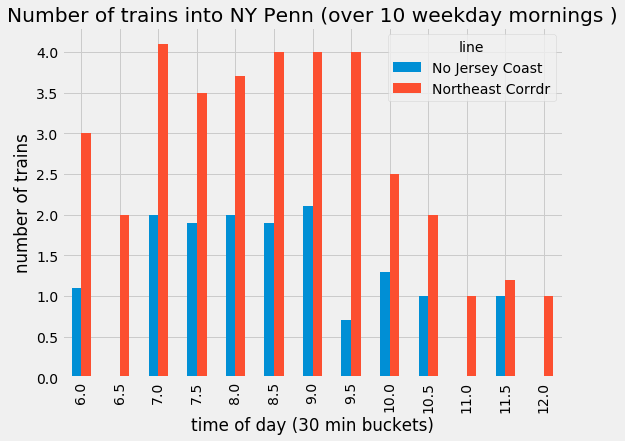

In [47]:
morning_trains = trains_by_line[(trains_by_line['time_of_day'] >= 6) & (trains_by_line['time_of_day'] <= 12)]
ax = morning_trains.plot(morning_delay['time_of_day'], y=['No Jersey Coast', 'Northeast Corrdr'], figsize=(8,6), kind="bar", title="Number of trains into NY Penn (over 10 weekday mornings )")
ax.set_xlabel('time of day (30 min buckets)')
ax.set_ylabel('number of trains')